## Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import os
import mne
import pickle
import itertools

from numba import jit, cuda

import pac


import Get_global_local_feature

## Get global feature using convolution

## Working on Kiani's PAC
### new pipline with normalization of channel
load PAC

In [ ]:
a = np.load('..\data\mvl_2ds_1_50.npz')
PAC = a['mvl_2ds']*1e-12
Test = Get_global_local_feature.conv_PAC_dist(PAC[0,0,0,0,0:64,:],h=4,w=4,down_sample_factor_h=4,down_sample_factor_w=4)
Test.shape

In [ ]:
PAC_feature_sub_on_electrodes = np.zeros(shape=(3,25,3,63,16,4))
@jit
def PAC_caluculation():
    for i in np.arange(3):
        for j in np.arange(3):
            for ch in np.arange(63):
                for sub in np.arange(25): 
                    PAC_feature_sub_on_electrodes[i,sub,j,ch,:,:] = Get_global_local_feature.conv_PAC_dist(PAC[i,sub,j,ch,0:64,:],h=4,w=4,down_sample_factor_h=4,down_sample_factor_w=4)

if __name__ == "__main__":
    PAC_caluculation()
    np.save(f'..\data\Feature_window_dimension_4_4.npy',PAC_feature_sub_on_electrodes)


### Load feature and set parameter

In [6]:
PAC_feature_sub_on_electrodes = np.load(f'..\data\Feature_window_dimension_4_4.npy')
groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']
PAC_feature_sub_on_electrodes.shape

(3, 25, 3, 63, 16, 4)

#### Get indexes of selected channels

In [74]:
with open('..\data\channels_name.pkl', 'rb') as f:
    channels_name = pickle.load(f)
selected_channels = ['Fz','Pz','Cz','FCz']
# selected_channels = ['FCz']
list_index = [channels_name.index(i) for i in selected_channels]
list_index

[1, 12, 23, 39]

## Get Local Features for time PAC series


In [ ]:
# Here load a matrix with shape of 3,25,3,63,num_High_fre,num_Low_fre,num_time_window=6 cotaining PAC values
Path = '/home/moh/Desktop/Surprise/Codes/brainsurprise2/brainsurprise/data/PAC_time_feature_8_30_25_100_total.mmap'
Num_High_fre = 76
Num_Low_fre = 23
PAC_distribution_time_window = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_fre ,Num_Low_fre,6),mode='r+')


# here you can set the dimention of Kernel filter and save path for 
Convolution_window_h = 4
Convolution_window_l = 4
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
Save_path = '../data/Test.mmap'
PAC_feature_time_window = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='w+')

# # Test
# PAC_feature_time_window[1,1,1,1,:,:,1] = Get_global_local_feature.conv_PAC_dist(PAC_distribution_time_window[1,1,1,1,:,:,1],
#                                          h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)


PAC_feature_time_window = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_low_feature,6),mode='w+')
window_size = 200 # in ms
down_sample_factor = 1
window_sample = int(window_size*(0.5/down_sample_factor))
frequency_h_n = 76
frequency_l_n = 23
start_high_frequency = 25
end_high_frequency = 100
start_low_frequency = 8
end_low_frequency = 30
frequency_range_high = np.linspace(start_high_frequency,end_high_frequency,frequency_h_n).astype(np.int64)
frequency_range_low = np.linspace(start_low_frequency,end_low_frequency,frequency_l_n).astype(np.int64)

PAC_feature_sub_on_electrodes = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63,frequency_h_n ,frequency_l_n,6),mode='r+')
# PAC_feature_sub_on_electrodes = np.zeros([3, 25, 3, 63,frequency_h_n ,frequency_l_n,6])
print(PAC_feature_sub_on_electrodes.flags)
def wrapper(i,sub,j,ch):
    for t in np.arange(6):
        PAC_feature_time_window[i,sub,j,ch,:,:,t] = Get_global_local_feature.conv_PAC_dist(PAC_distribution_time_window[i,sub,j,ch,:,:,t],
                                         h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)



Parallel(n_jobs=12,verbose=10)(delayed(wrapper)(i,sub,j,ch) for i in np.arange(3) for sub in np.arrange(25) for j in np.arrange(3) for ch in np.arrange(63))

## P value of feature

In [78]:
pv = np.zeros((PAC_feature_sub_on_electrodes.shape[3], 3, 3, 16, 4))
# for ch in range(PAC_feature_sub_on_electrodes.shape[3]):
for ch in list_index:    
#     print(ch)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        test_data1, test_data2 = PAC_feature_sub_on_electrodes[a, :, j, ch].copy(), PAC_feature_sub_on_electrodes[b, :, j, ch].copy()
        # for sub in range(PAC_feature_sub_on_electrodes.shape[1]):
        #     test_data1[:, sub] = sig.convolve2d(test_data1[:, sub], filt_wind, boundary='symm', mode='same')
        #     test_data2[:, sub] = sig.convolve2d(test_data2[:, sub], filt_wind, boundary='symm', mode='same')
        
        t, p = scipy.stats.ttest_ind(test_data1, test_data2,equal_var=False)
        p[p>0.05] = 1
        pv[ch, i, j]=(-np.log(p))

i=1

In [48]:
# x axis ticks formater
def format_func_x(value, tick_number):
    # find number of multiples of pi/2
    if tick_number%2 == 1:
        return f'({1+4*(value)},{1+4*(value+1)-1})'
# y axis ticks formater
def format_func_y(value, tick_number):
    # find number of multiples of pi/2
    if tick_number%2 == 1:
        return f'({10+4*(value)},{10+4*(value+1)-1})'

gamma = [1, 16]
beta  = [ 1, 4]
def plot_pac(pac, high_freq=gamma, low_freq=beta, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation='nearest', #'nearest',
#                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq),cmap='RdBu_r',**kwargs)

    if ax is None:
        plt.show()
        
    return im       

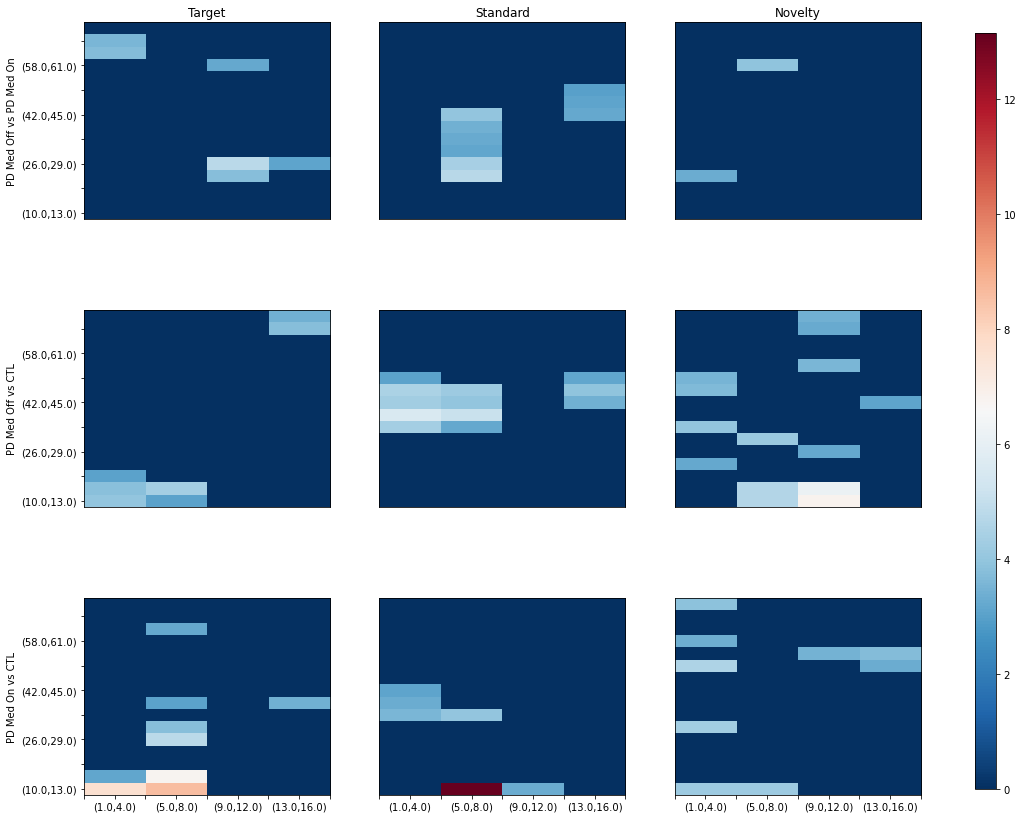

In [79]:
Path_to_save_fig = 'D:\Mastersharif\MasterProject\Working_with_kiani\\articles\Result_on_articles\Cbar_Corrected'
temp = pv.sum(axis=0)
vmax = temp.max()
vmin = temp.min()
max_1 = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
for i, j in itertools.product(range(3), range(3)):
    im = plot_pac(temp[i, j], ax=axs[i, j],vmin=vmin, vmax=vmax)
#                       vmin=vmin vmax=vmax)

    axs[i, j].xaxis.set_visible(False)
    axs[i, j].yaxis.set_visible(False)
    axs[i,j].xaxis.set_major_formatter(plt.FuncFormatter(format_func_x))
    axs[i,j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_y))
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)

fname = f'neq_var_p_value_dist_feature_h_feature_l_window_dimetion_4_RdBu_r_Selected_Chs_corrected_cbar'
file_path = os.path.join(Path_to_save_fig, fname)
plt.savefig(file_path)    

In [57]:
a=np.array([[3,2,5],[8,1,2],[6,6,7],[3,5,1]])
index = np.linspace(a.shape[0]-1,0,a.shape[0]).astype(np.int32)
a[index,:]


array([[3, 5, 1],
       [6, 6, 7],
       [8, 1, 2],
       [3, 2, 5]])

## How imshow plot work

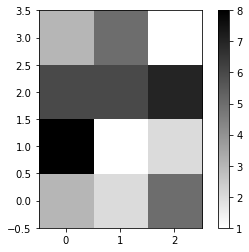

In [7]:
import numpy as np
import matplotlib.pyplot as plt

A=np.array([[3,2,5],[8,1,2],[6,6,7],[3,5,1]]) #The array to plot

im=plt.imshow(A,origin="lower",interpolation="nearest",cmap=plt.cm.gray_r)
plt.colorbar(im)

## Plot topography of important feature


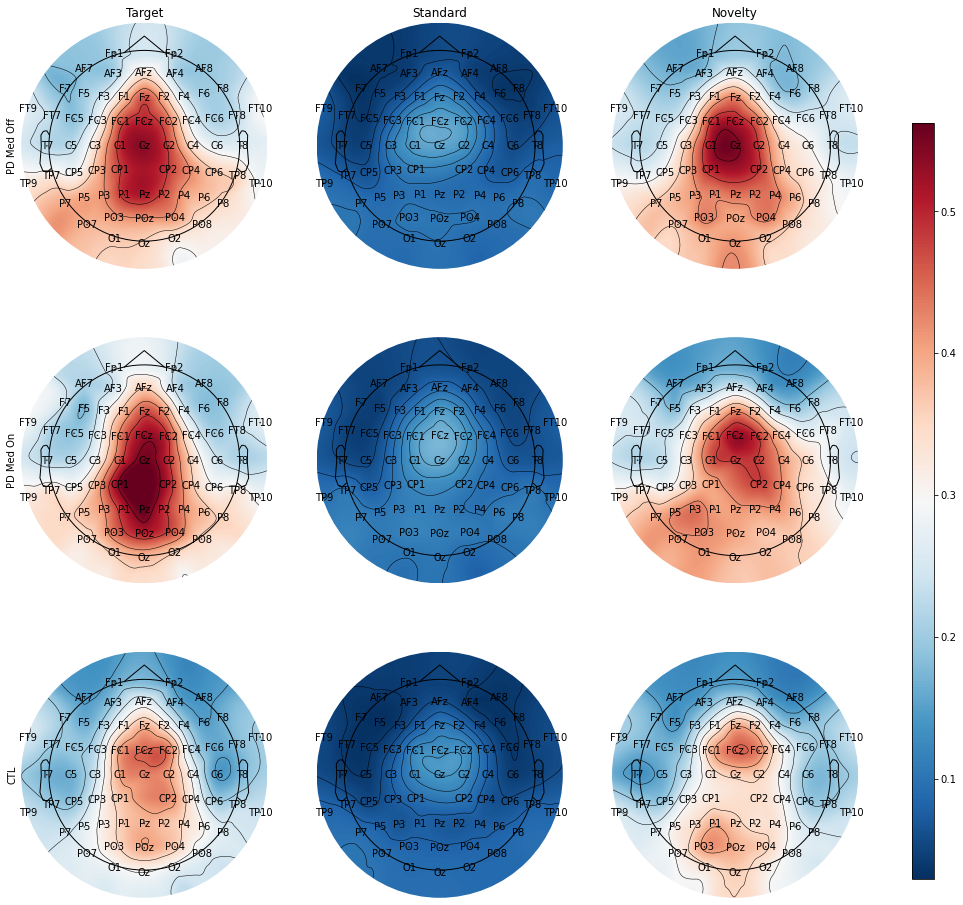

In [81]:
Path_to_save_fig = 'D:\Mastersharif\MasterProject\Working_with_kiani\\articles\Result_on_articles\\topography'

feature_h = 0
feature_l = 1
with open('..\data\channels_name.pkl', 'rb') as f:
        channels_name = pickle.load(f)
PAC_feature_sub_on_electrodes_gm = np.mean(PAC_feature_sub_on_electrodes[:,:,:,:,feature_h,feature_l],axis=1)
vmin = np.min(PAC_feature_sub_on_electrodes_gm)
vmax = np.max(PAC_feature_sub_on_electrodes_gm)
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))

mne_info = mne.create_info(ch_names=channels_name, sfreq=500., ch_types='eeg')

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')

for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    temp = np.expand_dims(PAC_feature_sub_on_electrodes_gm[i,j,:],axis=1)
    PAC_grand_mean = mne.EvokedArray(temp,mne_info)
    PAC_grand_mean.set_montage(montage)
    im, cm = mne.viz.plot_topomap(PAC_grand_mean.data[:,0], 
                                  PAC_grand_mean.info, axes=axs[i, j], show=False,
                                  names=channels_name, show_names=True, 
                                  vmin=vmin, vmax=vmax,res=200,cmap= 'RdBu_r',fontsize='medium')

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])
        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
fname = f'feature_h_{feature_h}_feature_l_{feature_l}_RdBu_r'
file_path = os.path.join(Path_to_save_fig, fname)
plt.savefig(file_path)

## P values on channel

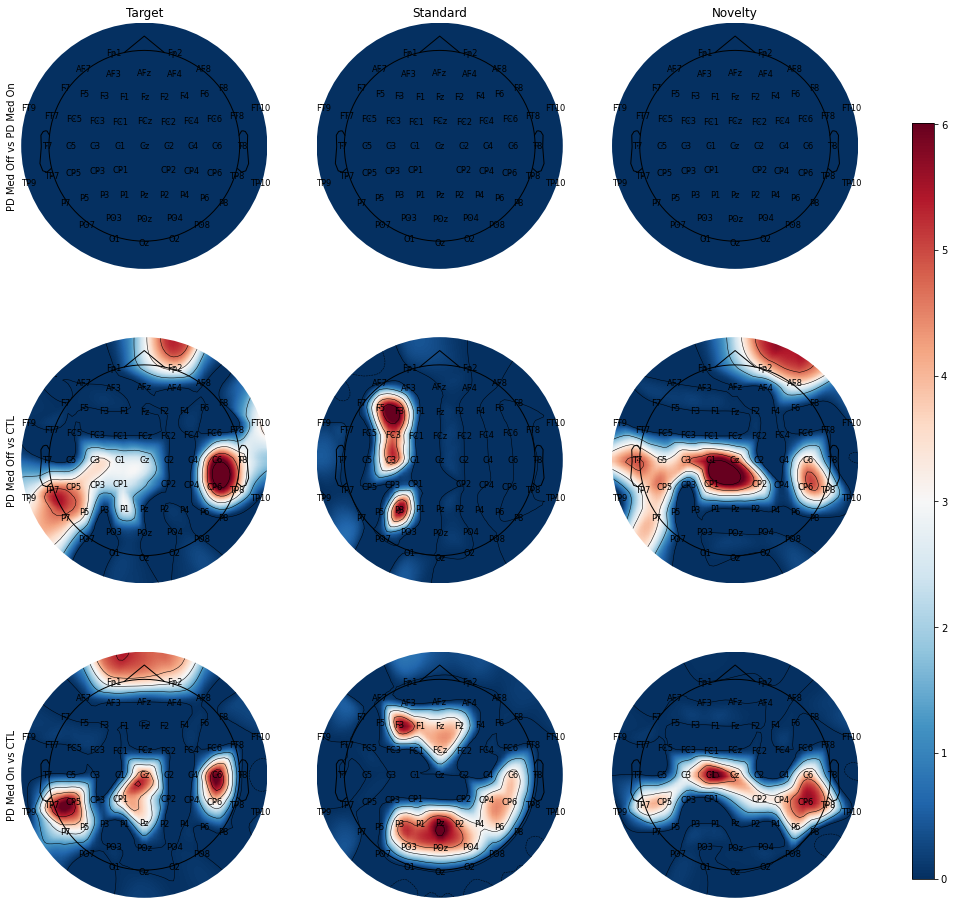

In [13]:
feature_h = 0
feature_l = 1
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
# vmin, vmax = mvls.mean(axis=1).min(), mvls.mean(axis=1).max() #get_percent(mvls.mean(axis=1), 0.95)
for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
    a, b = grp[0]
    i = grp[1]
    data_a = PAC_feature_sub_on_electrodes[a, :, j, :, feature_h, feature_l]
    data_b = PAC_feature_sub_on_electrodes[b, :, j, :, feature_h, feature_l]
    t, p = scipy.stats.ttest_ind(data_a, data_b)
    p[p>0.05] = 1
    p = p.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(-np.log(p) ,#- -np.log(p).mean(),
                                  mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0], 
                                  mvl_evoked.info, axes=axs[i, j], 
                                  show=False,
                                  names=channels_name, show_names=True, cmap='RdBu_r')
    #, vmin=vmin- mvls.mean(), vmax=vmax- mvls.mean())

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
fname = f'p_value_feature_h_{feature_h}_feature_l_{feature_l}_RdBu_r'
file_path = os.path.join(Path_to_save_fig, fname)
plt.savefig(file_path)